In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
from statsmodels.tsa.arima_model import ARIMA

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', 500)


In [2]:
# Read in average personal finance data
pf = pd.read_csv('average_personal_income_and_expense.csv', index_col=0, parse_dates=True)


In [3]:
# Sample onto daily timeframe
daily_pf = pf.resample('D', how='mean').interpolate(method='polynomial', order=5, limit_direction='both')


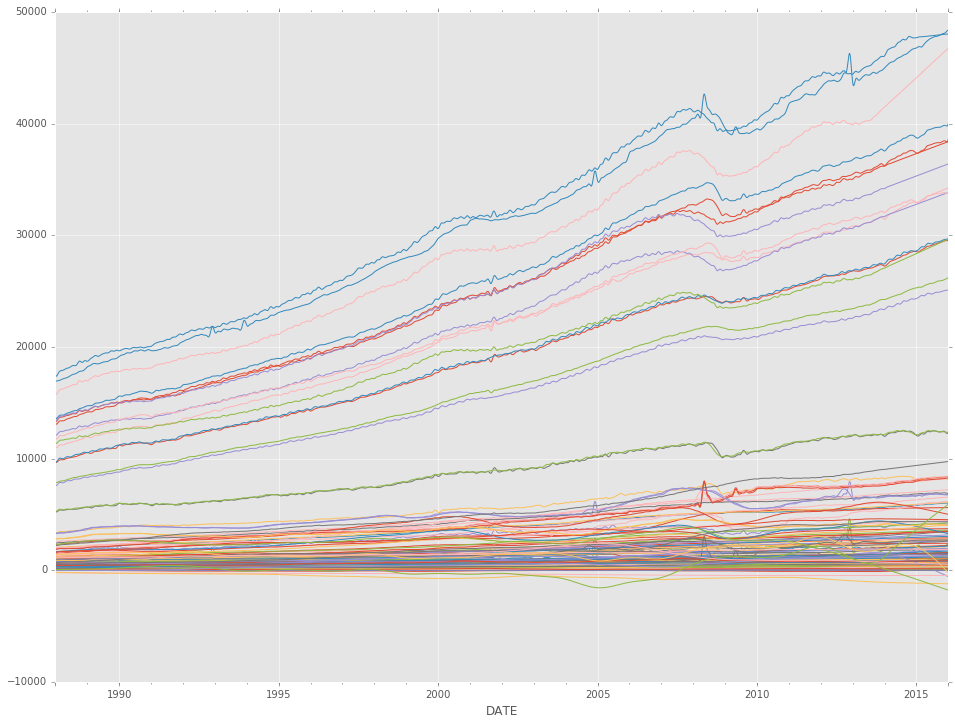

In [4]:
# Display
daily_pf.plot(legend=False)
